# Hierarchical timeseries

In [1]:
# Disable warnings
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hierarchical_prophet.prophet.prophet import Prophet
import matplotlib.pyplot as plt
from sktime.transformations.series.fourier import FourierFeatures
from sktime.forecasting.compose import ForecastingPipeline
from hierarchical_prophet.hierarchical_prophet import HierarchicalProphet
from numpyro import distributions as dist

# Import dataset

Here we use the tourism dataset with state-level aggregation.

In [2]:
from sktime.transformations.hierarchical.aggregate import Aggregator

data = pd.read_csv("tourism.csv")

data["Quarter"] = pd.PeriodIndex(data["Quarter"], freq="Q")
data = data.set_index(["Region", "Purpose", "State", "Quarter"])[["Trips"]]
data = data.droplevel([0,1]).sort_index()

y = (
    Aggregator(flatten_single_levels=False)
    .fit_transform(data)
    .groupby(level=[0, 1])
    .sum()
)
y

Trips
State   Quarter              
ACT     1998Q1     551.001921
        1998Q2     416.025623
        1998Q3     436.029011
        1998Q4     449.798445
        1999Q1     378.572817
...                       ...
__total 2015Q4   25759.429177
        2016Q1   27492.360374
        2016Q2   24791.797758
        2016Q3   24696.079808
        2016Q4   27017.077807

[608 rows x 1 columns]

In [3]:
STATES = y.index.get_level_values(0).unique()

def plot_preds(y, preds={}, axs=None):
    
    if axs is None:
        fig, axs = plt.subplots(figsize=(12, 8), nrows=int(np.ceil(len(STATES)/2)), ncols=2)
        ax_generator = iter(axs.flatten())
    for state in STATES:
        ax = next(ax_generator)
        y.loc[state].iloc[:, 0].rename("Observation").plot(ax=ax, label="truth", color="black")
        for name, _preds in preds.items():
            _preds.loc[state].iloc[:, 0].rename(name).plot(ax=ax, legend=True)
        ax.set_title(state)
        
    # Tight layout
    plt.tight_layout()
    return ax

# Fit univariate model

Because of sktime's amazing interface, we can use the univariate Prophet seamlessly with hierarchical data. We do not reconcile it here, but it could be achieved with the `Reconciler` class.

In [4]:
model = Prophet(
    trend="linear",
    n_changepoints=3,
    changepoint_prior_scale=0.01,
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    default_exogenous_prior=(dist.Normal, 0, .01),
    noise_scale=0.05,
    mcmc_chains=1,
    mcmc_samples=300,
    mcmc_warmup=1000,
)
model.fit(y=y)

sample: 100%|██████████| 1300/1300 [00:01<00:00, 942.22it/s, 7 steps of size 5.03e-01. acc. prob=0.86]  


Prophet(changepoint_prior_scale=0.01,
        default_exogenous_prior=(<class 'numpyro.distributions.continuous.Normal'>,
                                 0, 0.01),
        mcmc_chains=1, mcmc_samples=300, mcmc_warmup=1000, n_changepoints=3,
        yearly_seasonality=True)

## Verify the trace of MCMC


Verifying the trace of MCMC is a good way to check if the model has converged. If the trace is not stable, it is a sign that the model has not converged.


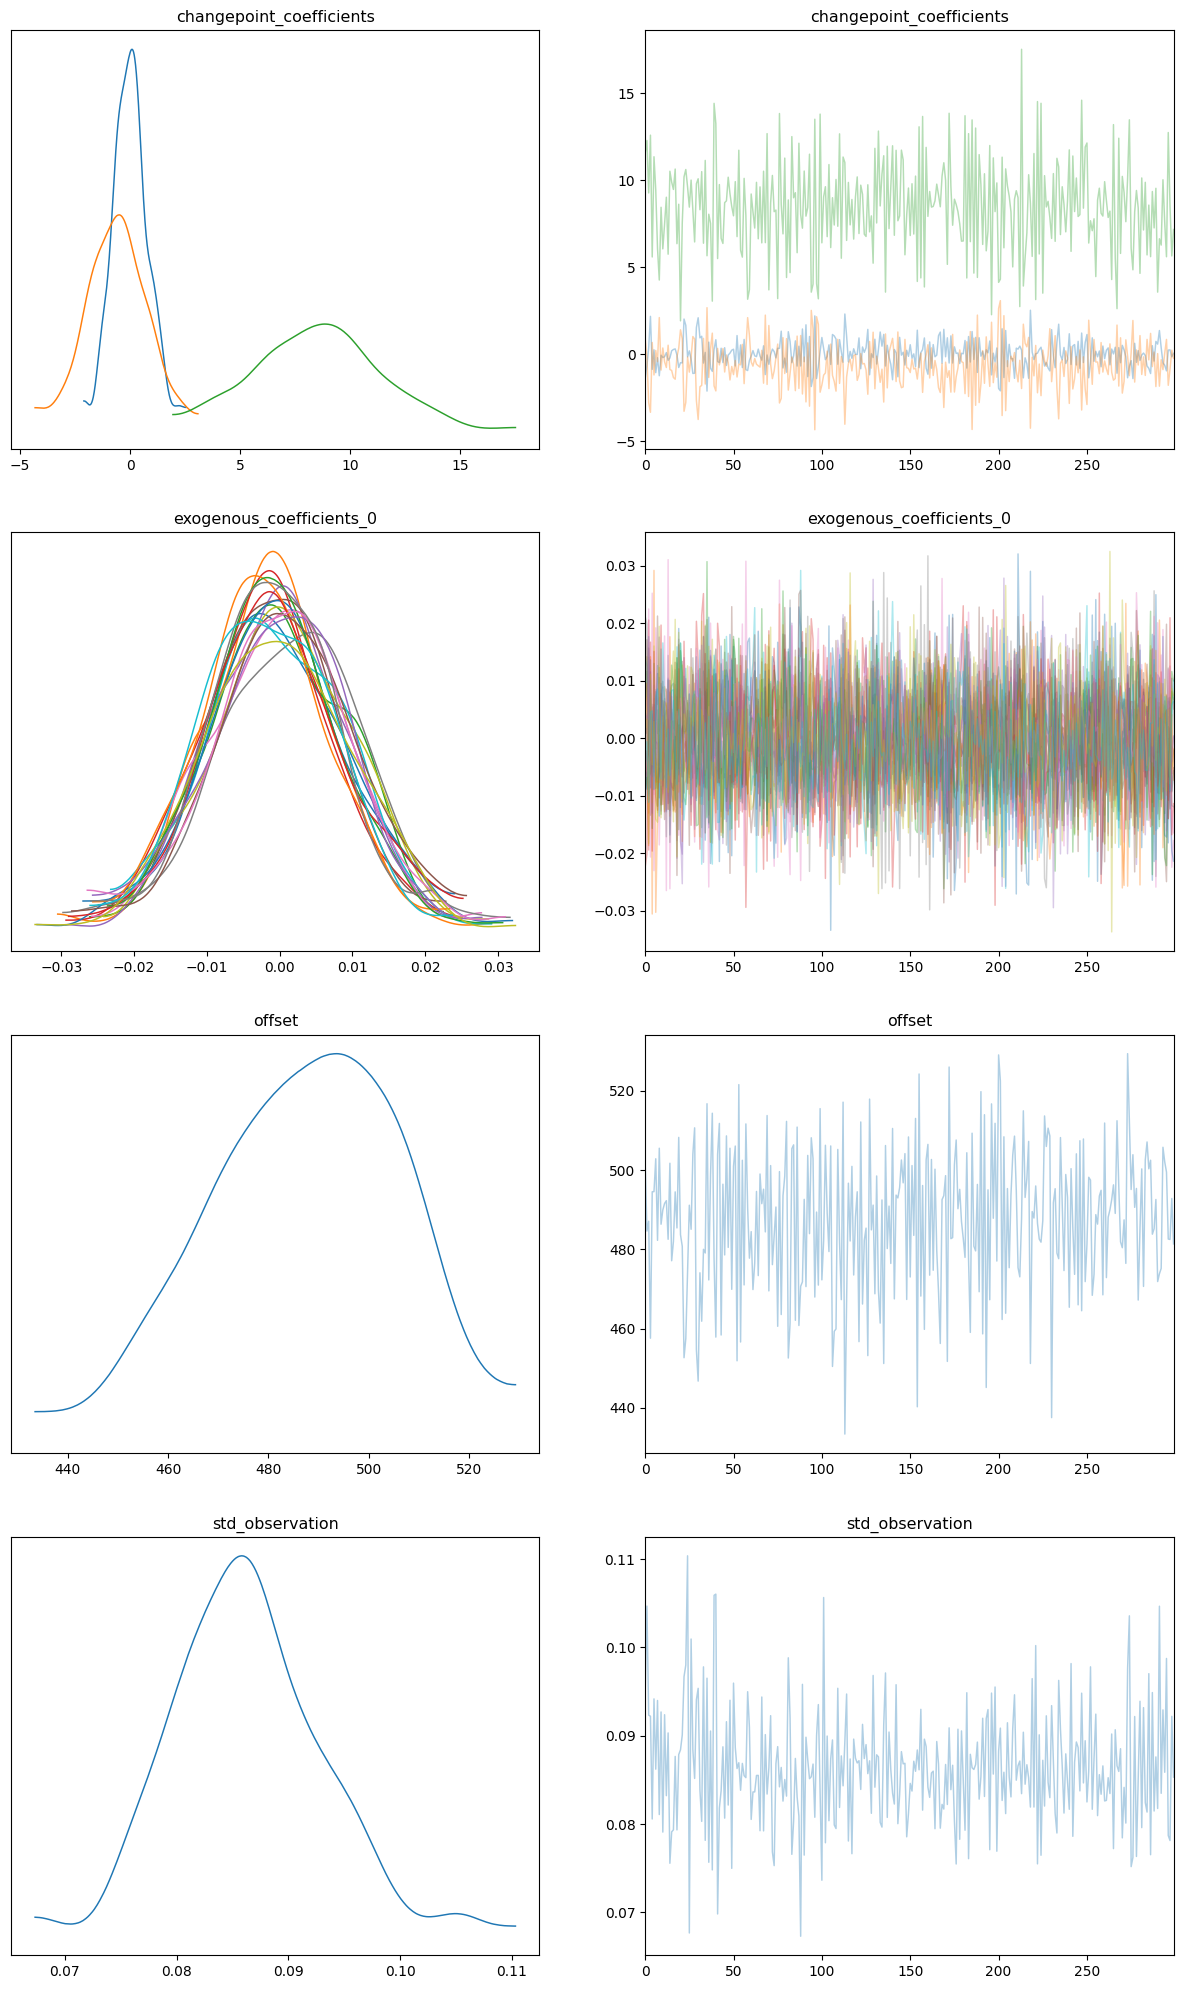

In [5]:
model.forecasters_.loc[STATES[0], "forecasters"].plot_trace()
plt.show()

## Forecasting

In [6]:
y

Trips
State   Quarter              
ACT     1998Q1     551.001921
        1998Q2     416.025623
        1998Q3     436.029011
        1998Q4     449.798445
        1999Q1     378.572817
...                       ...
__total 2015Q4   25759.429177
        2016Q1   27492.360374
        2016Q2   24791.797758
        2016Q3   24696.079808
        2016Q4   27017.077807

[608 rows x 1 columns]

In [7]:
model.forecasters_.iloc[0, 0].extra_inputs_["distributions"]["offset"].scale

66.7214141

<Axes: title={'center': '__total'}, xlabel='Quarter'>

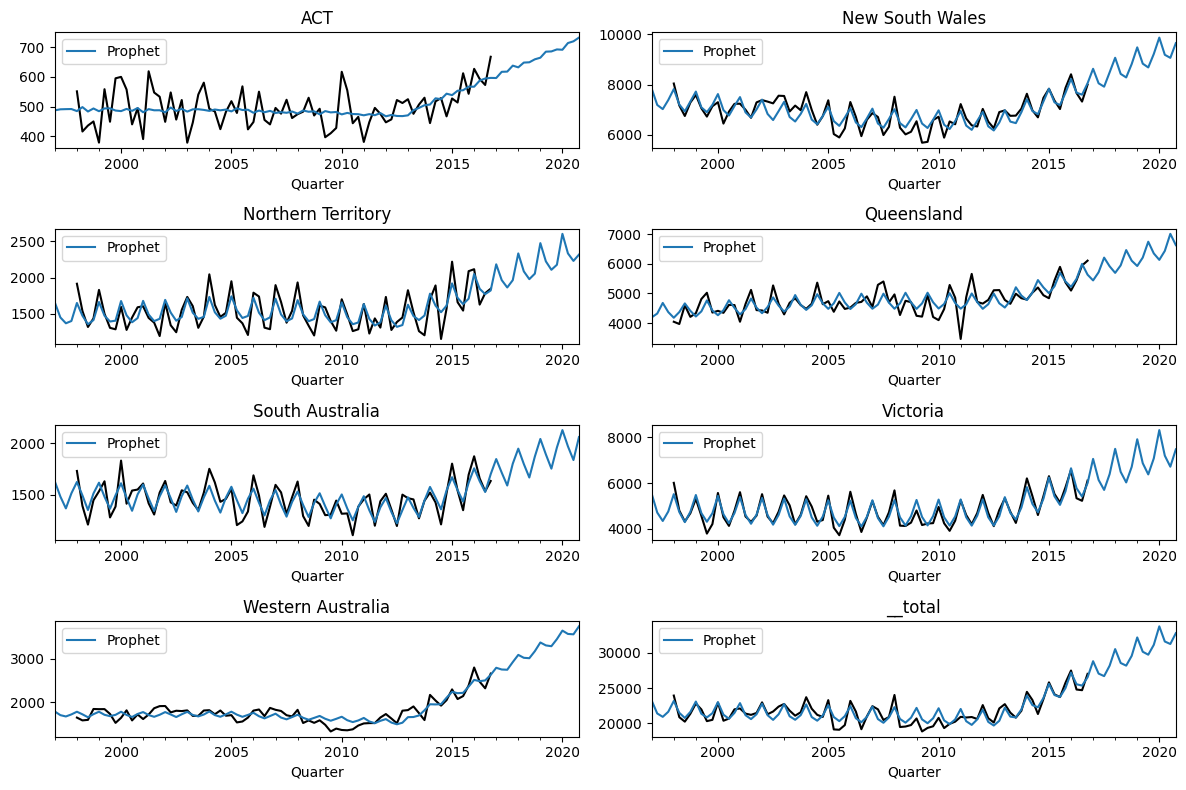

In [8]:
forecast_horizon = pd.period_range("1997Q1", "2020Q4", freq="Q")
preds = model.predict(fh=forecast_horizon)
plot_preds(y, {"Prophet": preds})

## Hierarchical Prophet

Now, let's use the hierarchical prophet to forecast all of the series at once. In addition, we will use the logistic growth model.

In [9]:
from hierarchical_prophet.hierarchical_prophet.prophet import HierarchicalProphet
model_hier = HierarchicalProphet(
                mcmc_chains=1,
                mcmc_samples=500,
                mcmc_warmup=2000,
                trend="logistic",
                seasonality_mode="multiplicative",
                changepoint_prior_scale=0.01,
                transformer_pipeline=FourierFeatures(
                    fourier_terms_list=[10], sp_list=["Y"]
                ),
                changepoint_interval=8,
                changepoint_range=-8,
                noise_scale=1,
                individual_regressors=["sin*", "cos*"],
                default_exogenous_prior=(dist.Normal, 0, 0.1),
            )


model_hier.fit(y=y)

sample: 100%|██████████| 2500/2500 [06:59<00:00,  5.97it/s, 1023 steps of size 8.46e-04. acc. prob=0.94]


HierarchicalProphet(changepoint_interval=8, changepoint_prior_scale=0.01,
                    changepoint_range=-8,
                    default_exogenous_prior=(<class 'numpyro.distributions.continuous.Normal'>,
                                             0, 0.1),
                    individual_regressors=['sin*', 'cos*'], mcmc_chains=1,
                    mcmc_samples=500, mcmc_warmup=2000, noise_scale=1,
                    transformer_pipeline=FourierFeatures(fourier_terms_list=[10],
                                                         sp_list=['Y']),
                    trend='logistic',
                    y_scales=array([ 667.2141, 8407.366 , 2217.1833, 6105.041 , 1874.7716, 6576.364 ,
       2797.4048], dtype=float32))

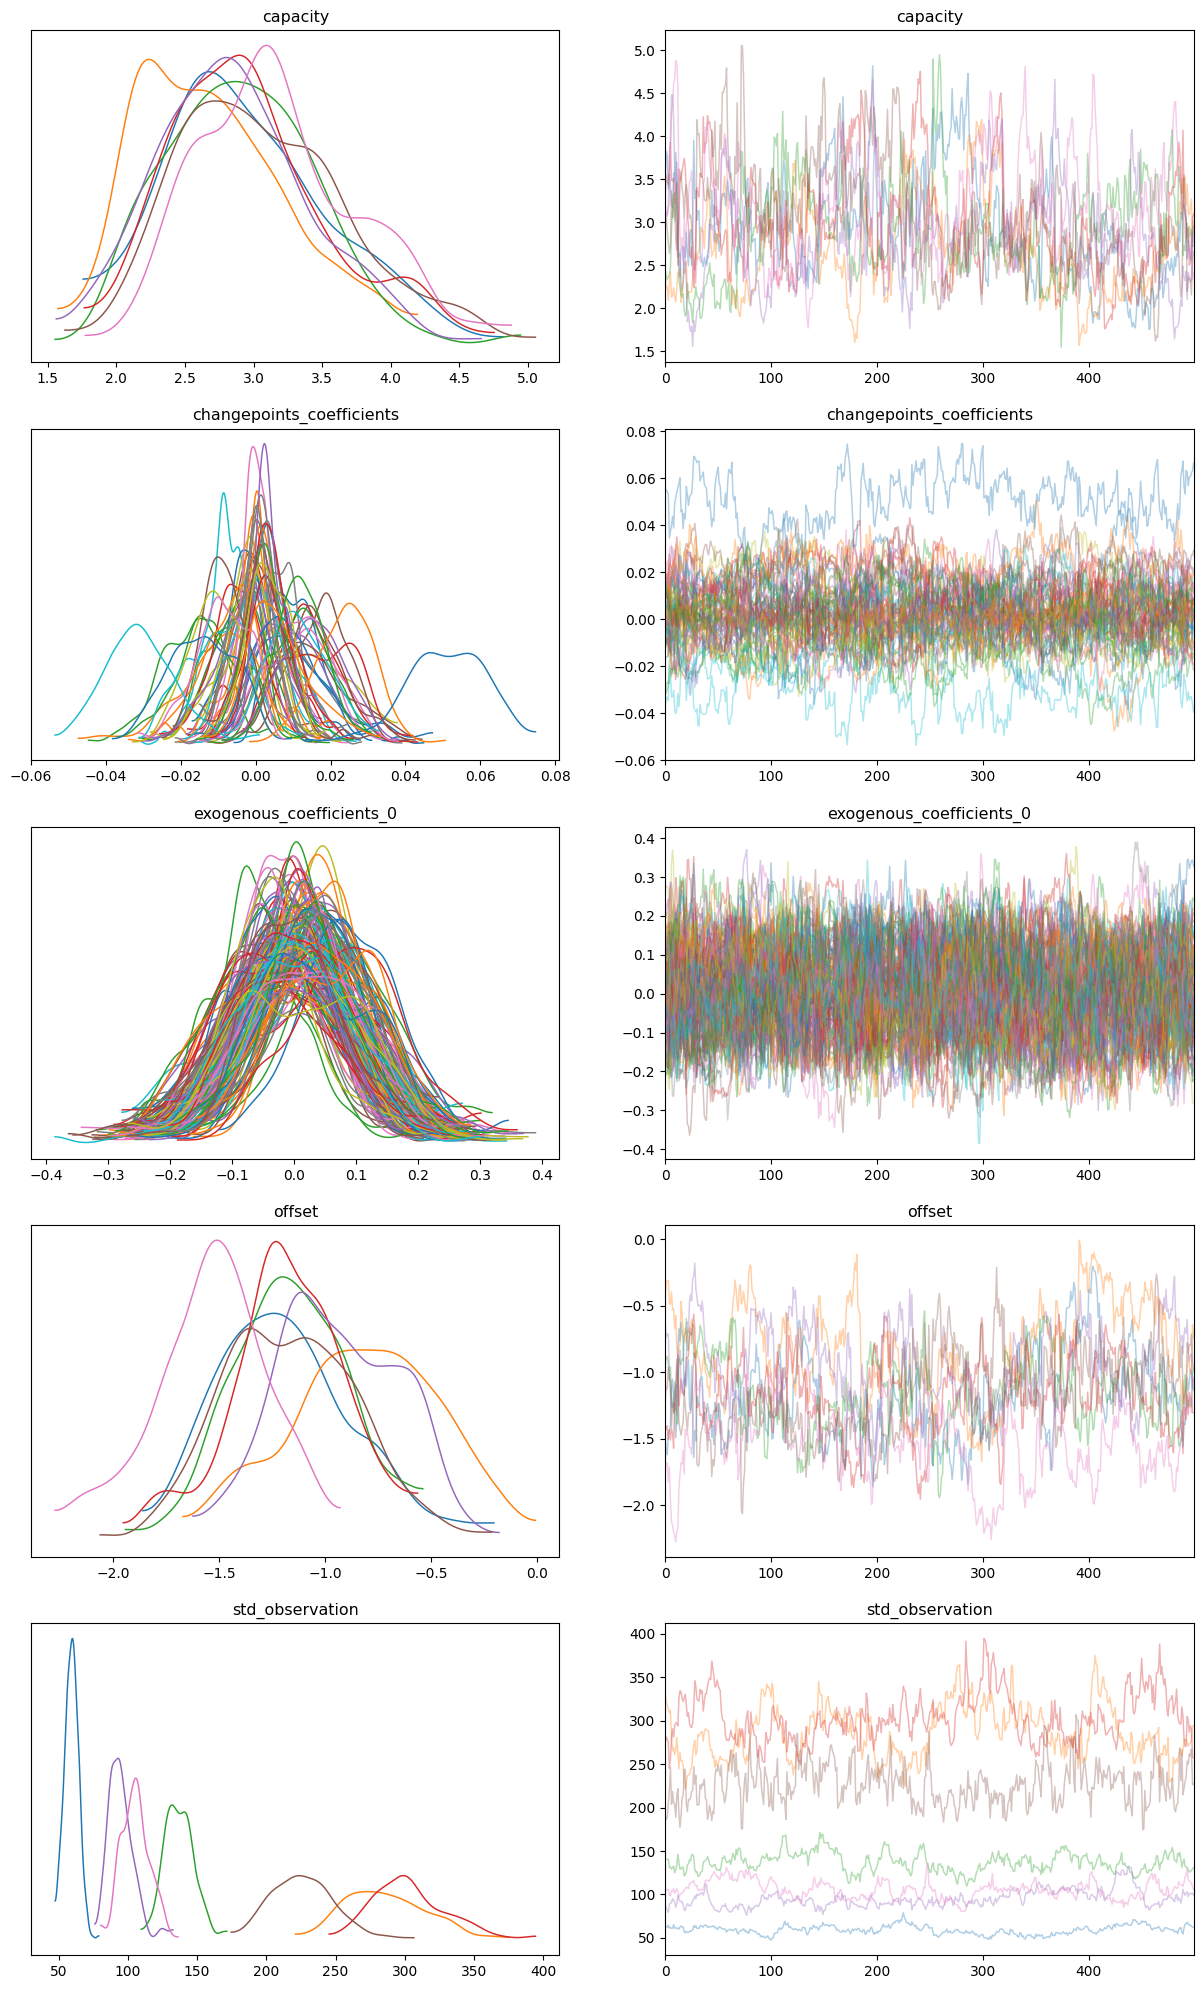

In [10]:
model_hier.plot_trace()
plt.show()

## Forecasting with hierarchical prophet

<Axes: title={'center': '__total'}, xlabel='Quarter'>

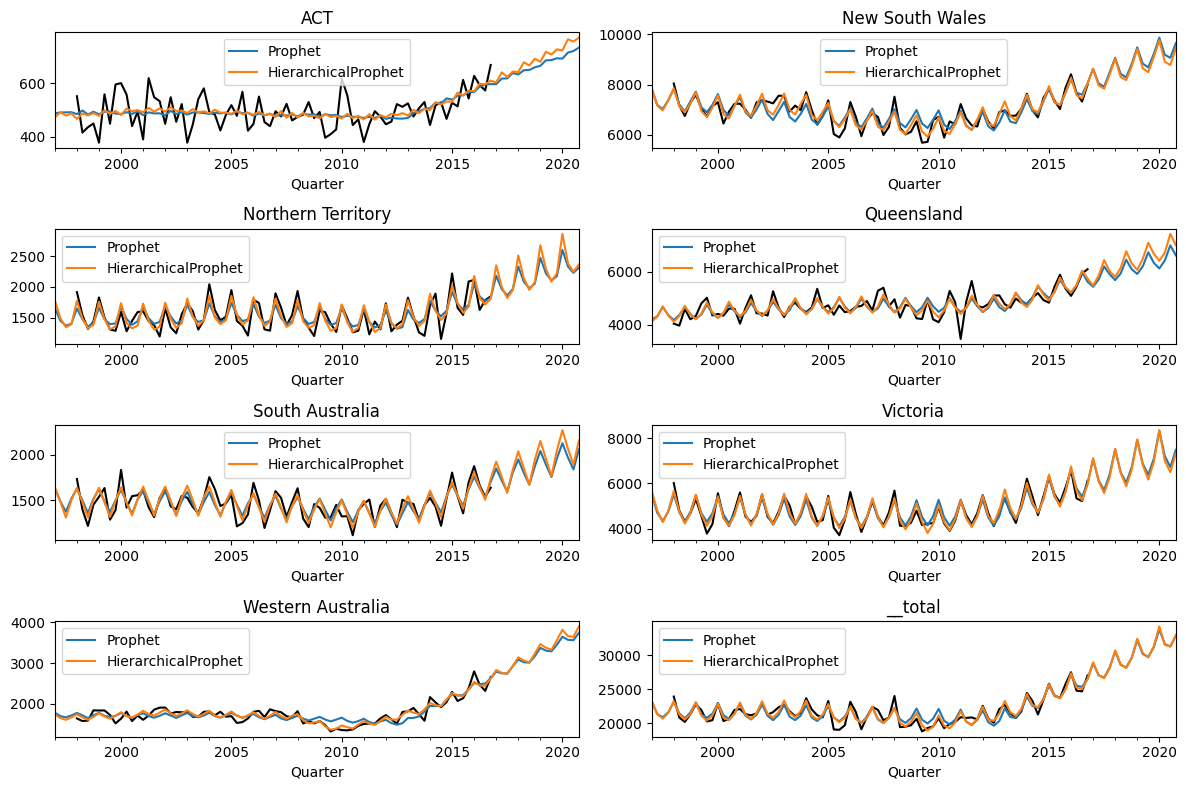

In [11]:
preds_hier = model_hier.predict(fh=forecast_horizon)

plot_preds(y, preds={
    "Prophet" : preds,
    "HierarchicalProphet" : preds_hier
})